In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

https://www.kaggle.com/aayushmishra1512/twitchdata

In [3]:
df = pd.read_csv('data/twitchdata-update.csv')
df.head()

,Channel,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Language
0,xQcOW,6196161750,215250,222720,27716,3246298,1734810,93036735,True,False,English
1,summit1g,6091677300,211845,310998,25610,5310163,1370184,89705964,True,False,English
2,Gaules,5644590915,515280,387315,10976,1767635,1023779,102611607,True,True,Portuguese
3,ESL_CSGO,3970318140,517740,300575,7714,3944850,703986,106546942,True,False,English
4,Tfue,3671000070,123660,285644,29602,8938903,2068424,78998587,True,False,English


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Channel               1000 non-null   object
 1   Watch time(Minutes)   1000 non-null   int64 
 2   Stream time(minutes)  1000 non-null   int64 
 3   Peak viewers          1000 non-null   int64 
 4   Average viewers       1000 non-null   int64 
 5   Followers             1000 non-null   int64 
 6   Followers gained      1000 non-null   int64 
 7   Views gained          1000 non-null   int64 
 8   Partnered             1000 non-null   bool  
 9   Mature                1000 non-null   bool  
 10  Language              1000 non-null   object
dtypes: bool(2), int64(7), object(2)
memory usage: 72.4+ KB


In [5]:
df.isnull().sum()

Channel                 0
Watch time(Minutes)     0
Stream time(minutes)    0
Peak viewers            0
Average viewers         0
Followers               0
Followers gained        0
Views gained            0
Partnered               0
Mature                  0
Language                0
dtype: int64

In [6]:
df.dtypes

Channel                 object
Watch time(Minutes)      int64
Stream time(minutes)     int64
Peak viewers             int64
Average viewers          int64
Followers                int64
Followers gained         int64
Views gained             int64
Partnered                 bool
Mature                    bool
Language                object
dtype: object

In [7]:
df.describe()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained
count,1.000000e+03,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03
mean,4.184279e+08,120515.160000,37065.051000,4781.040000,5.700541e+05,2.055185e+05,1.166817e+07
std,5.496355e+08,85376.201364,60314.307686,8453.684965,8.044134e+05,3.399137e+05,2.490572e+07
min,1.221928e+08,3465.000000,496.000000,235.000000,3.660000e+03,-1.577200e+04,1.757880e+05
25%,1.631899e+08,73758.750000,9113.750000,1457.750000,1.705462e+05,4.375825e+04,3.880602e+06
50%,2.349908e+08,108240.000000,16676.000000,2425.000000,3.180630e+05,9.835200e+04,6.456324e+06
75%,4.337399e+08,141843.750000,37569.750000,4786.250000,6.243322e+05,2.361308e+05,1.219676e+07
max,6.196162e+09,521445.000000,639375.000000,147643.000000,8.938903e+06,3.966525e+06,6.701375e+08


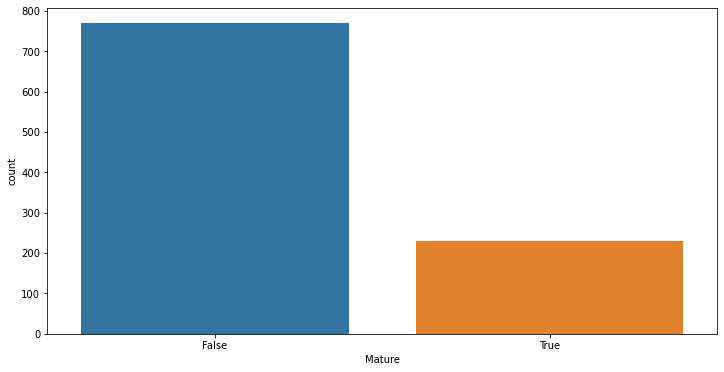

In [8]:
plt.figure(figsize=(12, 6))
plot = sns.countplot(x="Mature", data=df,order=df['Mature'].value_counts().index)

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54413 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54620 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-p

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 26292 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 23567 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 24314 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47084 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-p

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49660 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44277 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54785 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 20126 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-p

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 32645 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 20625 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54788 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 40860 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 29399 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-p

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 54413 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 54620 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\ma

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 27578 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 26775 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 51648 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\ma

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 47336 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 50500 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 44867 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 54592 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\ma

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 48660 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 53300 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 54663 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 22812 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 35997 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\ma

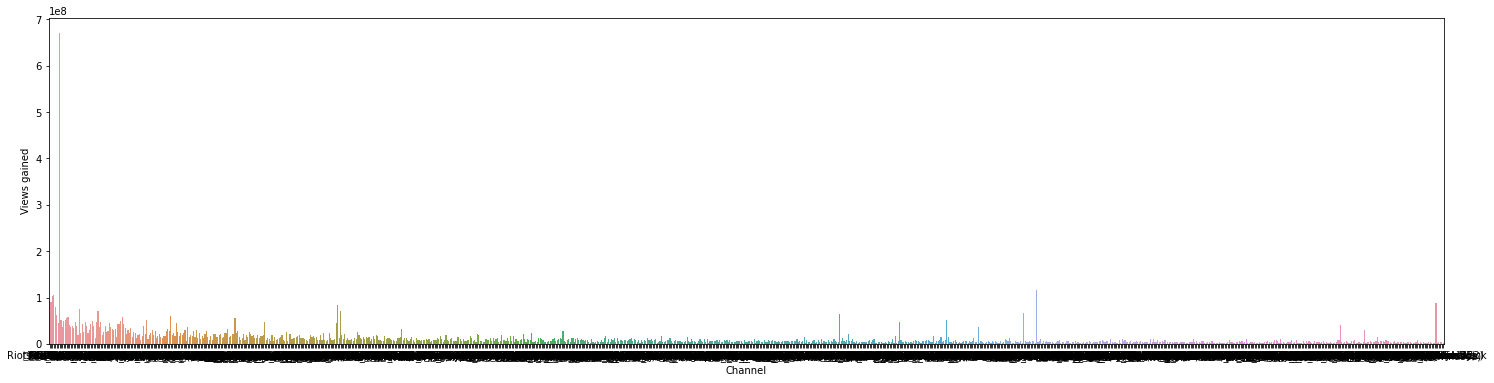

In [12]:
plt.figure(figsize=(25,6))
sns.barplot(x=df[df.Partnered == True]['Channel'], y=df[df.Partnered == True]['Views gained'],order=df[df.Partnered == True]['Channel'])
plt.show()

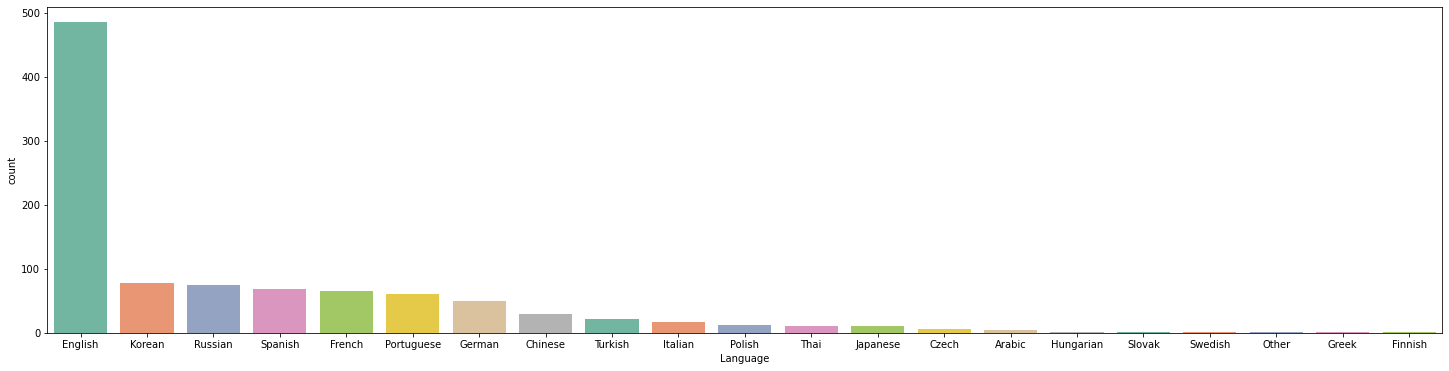

In [9]:
plt.figure(figsize=(25, 6))
plot = sns.countplot(x="Language", data=df,order=df['Language'].value_counts().index, palette="Set2")

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47084 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 45320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44368 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 47084 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 45320 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packa

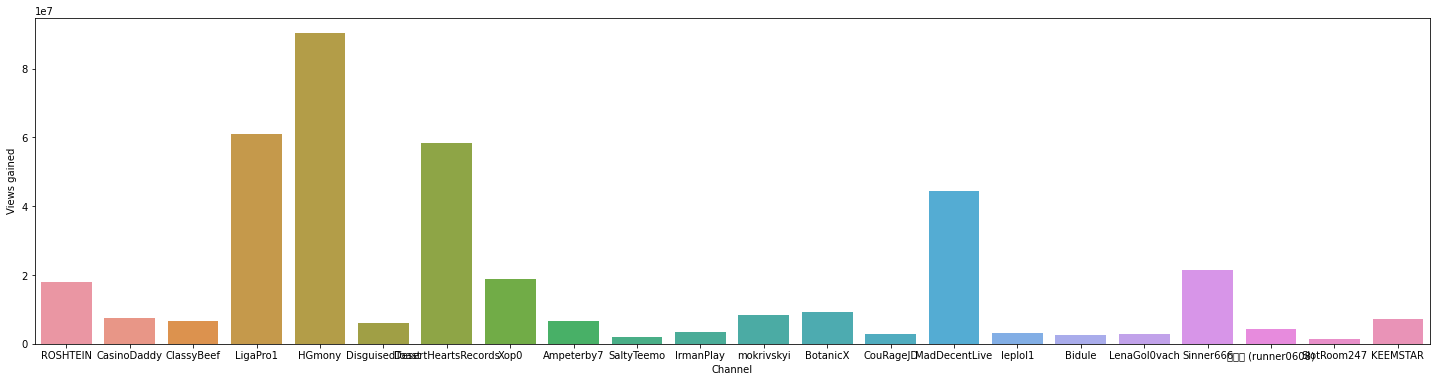

In [10]:
plt.figure(figsize=(25,6))
sns.barplot(x=df[df.Partnered == False]['Channel'] , y=df[df.Partnered == False]['Views gained'],order=df[df.Partnered == False]['Channel'])
plt.show()

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54413 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54620 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-p

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 35987 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50573 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 27578 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 26775 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-p

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 46965 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 22823 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 20024 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-p

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 53440 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 45796 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 55148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-p

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 54413 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 54620 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\ma

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 51648 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 45208 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 50724 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 53433 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\ma

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 32645 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 20625 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 54788 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\ma

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 45936 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 47476 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 54756 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 51669 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 45376 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\ma

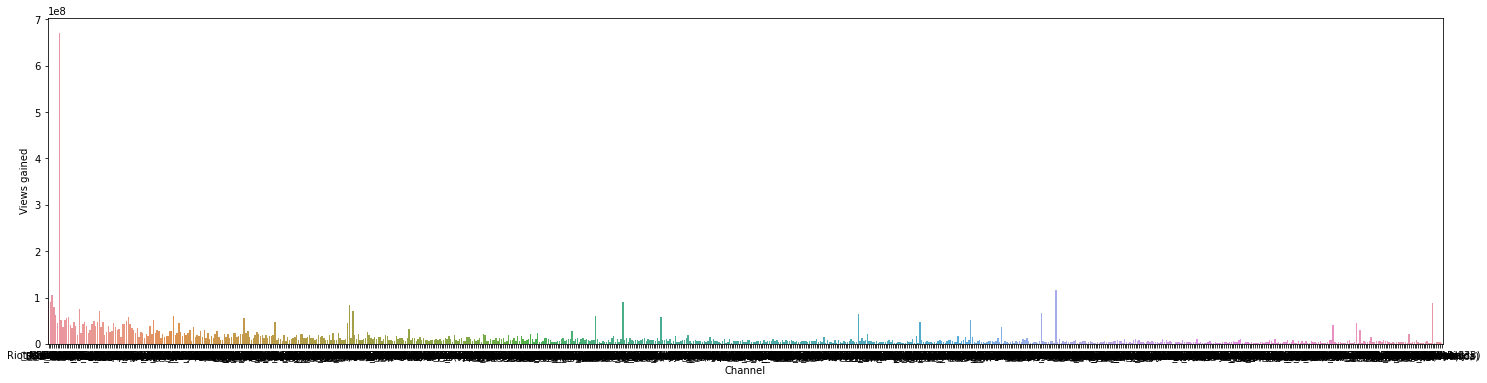

In [11]:
plt.figure(figsize=(25,6))
sns.barplot(x=df[df.Mature == False]['Channel'] , y=df[df.Mature == False]['Views gained'],order=df[df.Mature == False]['Channel'])
plt.show()

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 34662 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 24859 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 27224 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 23376 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 32769 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-p

C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 33655 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 23567 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 22812 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 35997 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 20811 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\ma

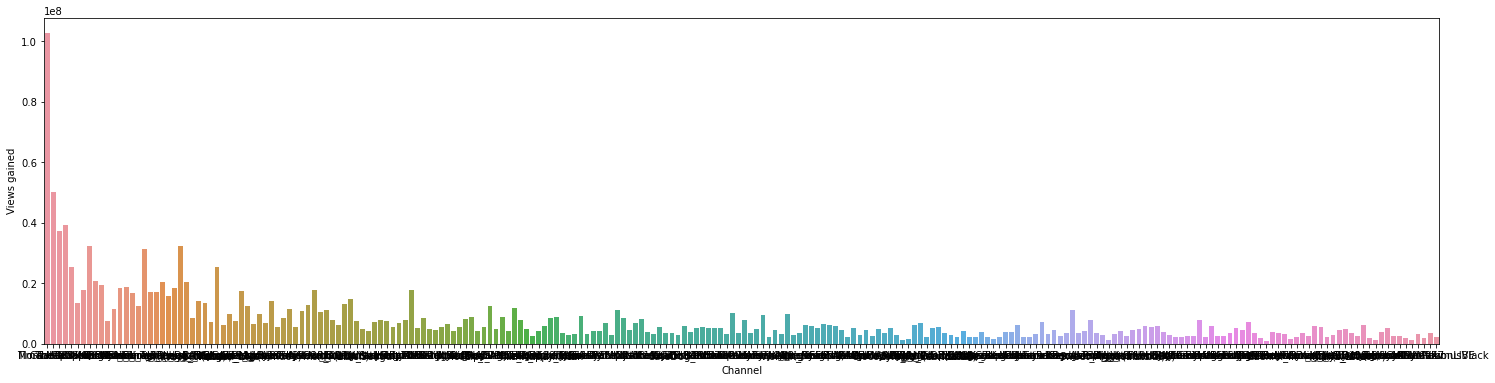

In [13]:
plt.figure(figsize=(25,6))
sns.barplot(x=df[df.Mature == True]['Channel'], y=df[df.Mature == True]['Views gained'],order=df[df.Mature == True]['Channel'])
plt.show()